# Annotate CD16+ T cells in COVID-19 patient flow cytometry data set

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime

In [3]:
import os
import re

In [4]:
sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cloudpickle         2.0.0
colorama            0.4.5
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.01.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
fsspec              2022.7.1
google              NA
h5py                3.1.0
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
llvmlite            0.38.1
markupsafe          2.1.1
matplotlib          3.5.3
mpl_toolkits        NA


Get date.

In [5]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

## Introduction

In this notebook, we preprocess COVID-19 FACS data, which have been collected in the [Georg et al. study](https://www.sciencedirect.com/science/article/pii/S0092867421015622?via%3Dihub) and were thankfully provided by Lorenzo Bonaguro as FlowJo Workspace archive. 

We annotate the data based on the previous FlowJo annotation.

Set data path.

In [7]:
path_data = './../../SL_FACS/data/Bonaguro-COVID19/'

Load data.

In [8]:
#save to file
adata = sc.read(path_data + 'H5AD/' + 'data_cd45pos_facs_covid_lb.h5ad') 

## Annotation

Let us annotate the cell type level 1 from the manual gates as B cells, T cells, monocytes, NK cells, and granulocytes. For cell type level 2, we resolve CD4+ and CD8+ T cells, NK T cells, Neutrophils, Eosinophils and classical/intermediate/non-classical monocytes. For cell type level 3, we resolve CD16+ T cells.

In [30]:
adata.obs['manual cell type lvl 1'] = pd.Categorical(np.repeat('not annotated', adata.n_obs), 
                                        categories=[ 'B cell', 'T cell', 'NK cell',
                                                    'Monocyte',
                                                    'Granulocyte',
                                                    'not annotated'])

In [31]:
b_cell_idx = adata.obs['gate_B cells']>0
t_cell_idx = adata.obs['gate_CD3+']>0
nk_cell_idx = adata.obs['gate_NK cells']>0
monocyte_idx = adata.obs['gate_monocytes']>0
granulo_idx = adata.obs['gate_Granulocytes']>0

adata.obs['manual cell type lvl 1'][b_cell_idx] = 'B cell'
adata.obs['manual cell type lvl 1'][t_cell_idx] = 'T cell'
adata.obs['manual cell type lvl 1'][nk_cell_idx] = 'NK cell'
adata.obs['manual cell type lvl 1'][monocyte_idx] = 'Monocyte'
adata.obs['manual cell type lvl 1'][granulo_idx] = 'Granulocyte'

In [32]:
adata.obs['manual cell type lvl 1'].value_counts()

Granulocyte      4009709
T cell           1122869
Monocyte          567716
NK cell           332657
not annotated     229520
B cell            162385
Name: manual cell type lvl 1, dtype: int64

Cell type level 2.

In [33]:
adata.obs['manual cell type lvl 2'] = adata.obs['manual cell type lvl 1'].cat.add_categories([ 
    'CD4+ T cell', 'CD8+ T cell', 'NKT cell', 'Classical monocyte', 
                                                    'Intermediate monocyte',
                                                    'Non-classical monocyte',
                                                    'Eosinophil', 'Neutrophil'])

In [34]:
cd4t_cell_idx = adata.obs['gate_CD4 T cells']>0
cd8t_cell_idx = adata.obs['gate_CD8 T cells']>0
nkt_cell_idx = adata.obs['gate_NKT']>0
classmonocyte_idx = adata.obs['gate_classical']>0
nclassmonocyte_idx = adata.obs['gate_CD16 mono']>0
intermonocyte_idx = adata.obs['gate_intermediate']>0

eosino_idx = adata.obs['gate_Eosinophils']>0
neutro_idx = adata.obs['gate_Neutrophils']>0

adata.obs['manual cell type lvl 2'][cd4t_cell_idx] = 'CD4+ T cell'
adata.obs['manual cell type lvl 2'][cd8t_cell_idx] = 'CD8+ T cell'
adata.obs['manual cell type lvl 2'][nkt_cell_idx] = 'NKT cell'
adata.obs['manual cell type lvl 2'][classmonocyte_idx] = 'Classical monocyte'
adata.obs['manual cell type lvl 2'][nclassmonocyte_idx] = 'Non-classical monocyte'
adata.obs['manual cell type lvl 2'][intermonocyte_idx] = 'Intermediate monocyte'
adata.obs['manual cell type lvl 2'][eosino_idx] = 'Eosinophil'
adata.obs['manual cell type lvl 2'][neutro_idx] = 'Neutrophil'

#rename remaining cells from super-categories 
adata.obs['manual cell type lvl 2'] = adata.obs['manual cell type lvl 2'].cat.rename_categories(
{'Monocyte' : 'Other monocyte',
 'Granulocyte' : 'Other granulocyte'
}
)
#
adata.obs['manual cell type lvl 2'] = adata.obs['manual cell type lvl 2'].cat.remove_unused_categories()

In [35]:
adata.obs['manual cell type lvl 2'].value_counts()

Neutrophil                3337791
CD4+ T cell                696369
Classical monocyte         457161
Eosinophil                 382915
NK cell                    332657
Other granulocyte          289003
CD8+ T cell                275466
not annotated              229520
B cell                     162385
T cell                      83371
NKT cell                    67663
Intermediate monocyte       51452
Other monocyte              35845
Non-classical monocyte      23258
Name: manual cell type lvl 2, dtype: int64

Cell type level 3.

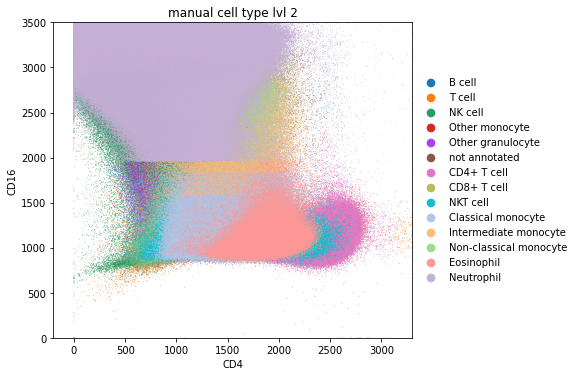

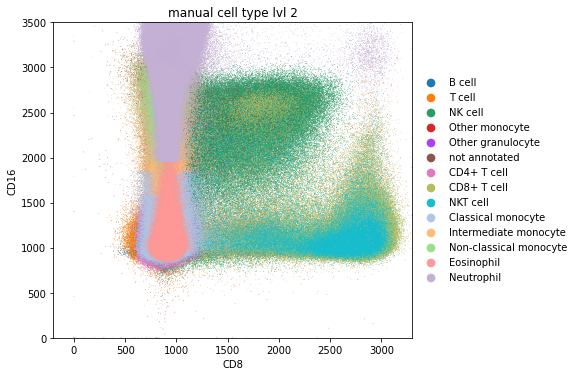

In [44]:
rcParams['figure.figsize']=(6,6)
ax = sc.pl.scatter(adata, x='CD4', y = 'CD16', color='manual cell type lvl 2', size=2, show=False)
ax.set_xlim([-200, 3300])
ax.set_ylim([0, 3500])
plt.show()

ax = sc.pl.scatter(adata, x='CD8', y = 'CD16', color='manual cell type lvl 2', size=2, show=False)
ax.set_xlim([-200, 3300])
ax.set_ylim([0, 3500])
plt.show()

Create a scatter plot of CD16 vs CD4.

In [42]:
adata_tmp=adata[adata.obs['manual cell type lvl 2'].isin(['CD4+ T cell', 'CD8+ T cell'])].copy()

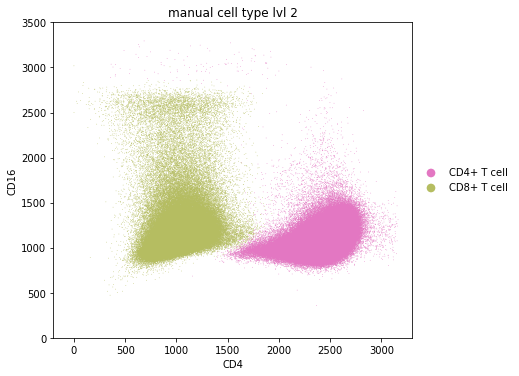

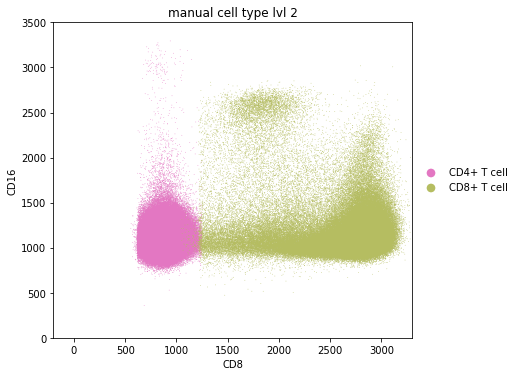

In [43]:
rcParams['figure.figsize']=(6,6)
ax = sc.pl.scatter(adata_tmp, x='CD4', y = 'CD16', color='manual cell type lvl 2', size=2, show=False)
ax.set_xlim([-200, 3300])
ax.set_ylim([0, 3500])
plt.show()

ax = sc.pl.scatter(adata_tmp, x='CD8', y = 'CD16', color='manual cell type lvl 2', size=2, show=False)
ax.set_xlim([-200, 3300])
ax.set_ylim([0, 3500])
plt.show()

Define CD16+ T cells as all T cells, which have a normalized CD16 fluorescent intensity above 2000 in accordance with the definition of neutrophils and non-classical monocytes.

In [52]:
cd16pos_idx = (adata.X[:, adata.var_names=='CD16']>2000).squeeze()

In [54]:
adata.obs['manual cell type lvl 3'] = adata.obs['manual cell type lvl 2'].cat.add_categories([ 
    'CD16+ CD4+ T cell', 'CD16+ CD8+ T cell'])

In [55]:
cd4t_cell_idx = adata.obs['gate_CD4 T cells']>0
cd8t_cell_idx = adata.obs['gate_CD8 T cells']>0


adata.obs['manual cell type lvl 3'][np.logical_and(cd4t_cell_idx, cd16pos_idx)] = 'CD16+ CD4+ T cell'
adata.obs['manual cell type lvl 3'][np.logical_and(cd8t_cell_idx, cd16pos_idx)] = 'CD16+ CD8+ T cell'

#
adata.obs['manual cell type lvl 3'] = adata.obs['manual cell type lvl 3'].cat.remove_unused_categories()

In [56]:
adata.obs['manual cell type lvl 3'].value_counts()

Neutrophil                3337791
CD4+ T cell                696032
Classical monocyte         457161
Eosinophil                 382915
NK cell                    332657
Other granulocyte          289003
CD8+ T cell                268472
not annotated              229520
B cell                     162385
T cell                      83371
NKT cell                    67663
Intermediate monocyte       51452
Other monocyte              35845
Non-classical monocyte      23258
CD16+ CD8+ T cell            6994
CD16+ CD4+ T cell             337
Name: manual cell type lvl 3, dtype: int64

## Save to file

In [57]:
adata.write(f'{path_data}H5AD/data_cd45pos_facs_covid_anno_lb.h5ad')